In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from six import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
!pip install imblearn

In [3]:
from our_functions import display_acc_and_f1_score

In [4]:
df = pd.read_csv('data/cleaned_data.csv')

In [5]:
df.head()

,sample_pk,commod,commtype,lab,pestcode,lod,annotate,avg_detect,extract,determin,concentration
0,239,AJ,RE,WA1,083,0.005,Q,O,805,35,80000.0
1,1183,BR,FR,FL1,AFU,0.010,V,O,805,52,110000.0
2,1196,BR,FR,FL1,AFU,0.010,V,O,805,52,130000.0
3,1230,BR,FR,FL1,144,0.005,V,O,805,35,350000.0
4,1269,BR,FR,FL1,180,0.010,V,O,805,52,260000.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4887 entries, 0 to 4886
Data columns (total 11 columns):
sample_pk        4887 non-null int64
commod           4887 non-null object
commtype         4887 non-null object
lab              4887 non-null object
pestcode         4887 non-null object
lod              4887 non-null float64
annotate         4887 non-null object
avg_detect       4887 non-null object
extract          4887 non-null int64
determin         4887 non-null int64
concentration    4887 non-null float64
dtypes: float64(2), int64(3), object(6)
memory usage: 420.1+ KB


## Split data

In [53]:
X = df.drop(['annotate'], axis=1)
y = df.annotate

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=20)

## One-hot-encode data. We'll categories so the two sets have matching columns.

In [55]:
categoricals = ['commod', 'commtype', 'lab', 'pestcode', 'avg_detect']

In [96]:
encoder= OneHotEncoder(categories = 'auto', handle_unknown='ignore')
encoder = encoder.fit(X[categoricals])
encoder

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [107]:
#transform and dataframe train set
e_t = encoder.transform(X_train[categoricals])

ohe_train = pd.DataFrame(e_t.toarray(), 
                  columns=encoder.get_feature_names())
ohe_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3909 entries, 0 to 3908
Columns: 184 entries, x0_AJ to x4_R
dtypes: float64(184)
memory usage: 5.5 MB


In [109]:
#combine all variables
enc_X_train = X_train.join(ohe_train).drop(categoricals, axis=1)
enc_X_train.head()

,sample_pk,lod,extract,determin,concentration,x0_AJ,x0_BR,x0_BU,x0_CE,x0_CF,...,x3_B72,x3_B75,x3_B77,x3_B79,x3_B80,x3_B82,x3_B84,x3_B85,x4_O,x4_R
3645,7174,0.003,805,52,5.000000e+04,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4643,9886,30.000,811,52,5.000000e+14,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3556,7108,0.001,805,52,2.000000e+04,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3370,6959,0.008,805,52,1.300000e+05,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4563,9840,0.003,805,52,5.000000e+04,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
#Fill nans for modeling
enc_X_train.fillna(0, inplace=True)
enc_X_train.head()

,sample_pk,lod,extract,determin,concentration,x0_AJ,x0_BR,x0_BU,x0_CE,x0_CF,...,x3_B72,x3_B75,x3_B77,x3_B79,x3_B80,x3_B82,x3_B84,x3_B85,x4_O,x4_R
3645,7174,0.003,805,52,5.000000e+04,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4643,9886,30.000,811,52,5.000000e+14,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3556,7108,0.001,805,52,2.000000e+04,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3370,6959,0.008,805,52,1.300000e+05,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4563,9840,0.003,805,52,5.000000e+04,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
#encode and dataframe our test data
# don't forget we need to only fit to our training data, then transform it to both.
e_test = encoder.transform(X_test[categoricals])
ohe_test = pd.DataFrame(e_test.toarray(), 
                  columns=encoder.get_feature_names())
ohe_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Columns: 184 entries, x0_AJ to x4_R
dtypes: float64(184)
memory usage: 1.4 MB


In [110]:
#combine all variables
enc_X_test = X_test.join(ohe_train).drop(categoricals, axis=1)
enc_X_test.head()

,sample_pk,lod,extract,determin,concentration,x0_AJ,x0_BR,x0_BU,x0_CE,x0_CF,...,x3_B72,x3_B75,x3_B77,x3_B79,x3_B80,x3_B82,x3_B84,x3_B85,x4_O,x4_R
687,2202,0.0014,805,35,2.300000e+04,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
406,1968,0.0014,805,35,2.300000e+04,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2173,3800,0.0150,805,52,2.500000e+05,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4385,9683,0.2100,811,52,3.500000e+12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4823,9916,0.6100,811,52,1.020000e+13,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
#Fill nans for modeling
enc_X_test.fillna(0, inplace=True)
enc_X_test.head()

,sample_pk,lod,extract,determin,concentration,x0_AJ,x0_BR,x0_BU,x0_CE,x0_CF,...,x3_B72,x3_B75,x3_B77,x3_B79,x3_B80,x3_B82,x3_B84,x3_B85,x4_O,x4_R
687,2202,0.0014,805,35,2.300000e+04,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
406,1968,0.0014,805,35,2.300000e+04,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2173,3800,0.0150,805,52,2.500000e+05,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4385,9683,0.2100,811,52,3.500000e+12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4823,9916,0.6100,811,52,1.020000e+13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Nearest neighbors model

In [117]:
knc = KNeighborsClassifier()
knc.fit(enc_X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [118]:
k_preds = knc.predict(enc_X_test)

In [20]:
np.unique(k_preds, return_counts=True)

(array(['Q', 'QV', 'V', 'X'], dtype=object), array([951,   7,  17,   3]))

In [119]:
knc.score(enc_X_test, y_test)

0.9519427402862985

In [ ]:
knc.predict_proba()

## Logistic regression model

In [22]:
import statsmodels.api as sm

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
mul_r = LogisticRegression(multi_class='multinomial', solver='lbfgs')
mul_r.fit(enc_X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
mul_r.score(enc_X_test, y_test)

0.9294478527607362

In [26]:
mul_r.score(enc_X_train, y_train)

0.9270913277052955

In [102]:
#better metric
mul_r.predict_proba(enc_X_train, y_train)

TypeError: predict_proba() takes 2 positional arguments but 3 were given

It looks like our target variable has an abnormal distribution.

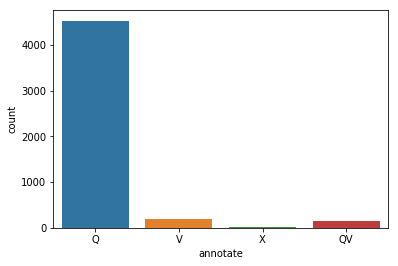

In [27]:
sns.countplot(x=df['annotate'], data=df)

We'll resample to improve target representation.

In [28]:
smote = SMOTE('not majority')
X_smote, y_smote = smote.fit_resample(enc_X_train, y_train)

In [29]:
np.unique(y_smote, return_counts=True)

(array(['Q', 'QV', 'V', 'X'], dtype=object), array([3624, 3624, 3624, 3624]))

There's an even distribution, so now we'll train our models on the SMOTE data.

In [30]:
knc = KNeighborsClassifier()
knc.fit(X_smote, y_smote)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [31]:
knc.score(enc_X_test, y_test)

0.8844580777096115

0.873 is still quite high. 

In [32]:
mul_r = LogisticRegression(multi_class='multinomial', solver='lbfgs')
mul_r.fit(X_smote, y_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
mul_r.score(X_smote, y_smote)

0.25